## Data Preprocessing and Visualisation

### Imports

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import sys  

### Data Preprocessing

In [23]:
# Data file paths
polygon_file = './data/polygon_data.csv'
scroll_file = './data/scroll_data.csv'
linea_file = './data/linea_data.csv'
zklink_file = './data/zklink_data.csv'

# Load data into dataframes
df_polygon = pd.read_csv(polygon_file)
df_scroll = pd.read_csv(scroll_file)
df_linea = pd.read_csv(linea_file)
df_zklink = pd.read_csv(zklink_file)

# Column to identify the chain
df_polygon['Chain'] = 'Polygon'
df_scroll['Chain'] = 'Scroll'
df_linea['Chain'] = 'Linea'
df_zklink['Chain'] = 'zkLink'

# Combine dataframes
df = pd.concat([df_polygon, df_scroll, df_linea, df_zklink], ignore_index=True)

In [24]:
df.head()

,Transaction Hash,Block Number,Timestamp,Gas Price (Gwei),Gas Used,Number of Inputs,Max Merkle Tree Depth,Chain
0,3cb512fd12485807e729c42738b86ec053153fb74c02b8...,16640242,1728333000,0.394,643006,4,2,Polygon
1,6a16e089c0f7c739503f0d9c2057f721857d03440e2e27...,16240786,1727058609,0.103,588532,4,13,Polygon
2,45f61947d6b56de330ac22bdaf5f357bc32b2eff21f126...,16655055,1728383402,0.168,636043,4,2,Polygon
3,2eb3c9d1d6bfcac3ffbcef523199f92a489ac9b611ca95...,16164484,1726828206,0.133,629033,4,2,Polygon
4,f6d239c679479305284bf6921d594c665cf8044f285918...,16903154,1729231200,1.090,631922,4,2,Polygon


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667 entries, 0 to 7666
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Transaction Hash       7667 non-null   object 
 1   Block Number           7667 non-null   int64  
 2   Timestamp              7667 non-null   int64  
 3   Gas Price (Gwei)       7667 non-null   float64
 4   Gas Used               7667 non-null   int64  
 5   Number of Inputs       7667 non-null   int64  
 6   Max Merkle Tree Depth  7667 non-null   int64  
 7   Chain                  7667 non-null   object 
dtypes: float64(1), int64(5), object(2)
memory usage: 479.3+ KB


In [26]:
# Convert columns to relevant data types
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Gas Price (Gwei)'] = pd.to_numeric(df['Gas Price (Gwei)'], errors='coerce')
df['Gas Used'] = pd.to_numeric(df['Gas Used'], errors='coerce')
df['Number of Inputs'] = pd.to_numeric(df['Number of Inputs'], errors='coerce')
df['Max Merkle Tree Depth'] = pd.to_numeric(df['Max Merkle Tree Depth'], errors='coerce')

#### Fetching Historical ETH/USD price

In [27]:
# Round timestamps to the nearest day
df['Timestamp_Rounded'] = df['Timestamp'].dt.floor('D')
unique_timestamps = df['Timestamp_Rounded'].unique()

In [28]:
# Get the earliest and latest timestamps in the dataframe
start_timestamp = int(df['Timestamp'].min().timestamp())
end_timestamp = int(df['Timestamp'].max().timestamp())

def fetch_eth_price_range(start_timestamp, end_timestamp):
    """
    Fetch ETH/USD prices over a date range from CoinGecko API.
    """
    url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range'
    params = {
        'vs_currency': 'usd',
        'from': start_timestamp,
        'to': end_timestamp
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        prices = data['prices']
        return prices
    except Exception as e:
        print(f"Error fetching price data: {e}")
        return None

# Fetch price data
prices = fetch_eth_price_range(start_timestamp, end_timestamp)

# Check if prices were fetched successfully
if prices is None:
    print("Failed to fetch ETH price data.")
else:
    # Create a DataFrame from the price data
    prices_df = pd.DataFrame(prices, columns=['timestamp', 'ETH Price (USD)'])
    prices_df['timestamp'] = pd.to_datetime(prices_df['timestamp'], unit='ms')

    # Sort the DataFrames
    df.sort_values('Timestamp', inplace=True)
    prices_df.sort_values('timestamp', inplace=True)

    # Perform asof merge
    df = pd.merge_asof(df, prices_df, left_on='Timestamp', right_on='timestamp', direction='backward')

    # Calculate Total Cost in ETH and USD
    df['Gas Price (ETH)'] = df['Gas Price (Gwei)'] * 1e-9
    df['Total Cost (ETH)'] = df['Gas Used'] * df['Gas Price (ETH)']
    df['Total Cost (USD)'] = df['Total Cost (ETH)'] * df['ETH Price (USD)']

    # Verify mapping
    num_missing = df['Total Cost (USD)'].isna().sum()
    print(f"Number of transactions with missing Total Cost (USD): {num_missing}")



Number of transactions with missing Total Cost (USD): 4


In [29]:
# Drop rows without Total Cost (USD)
df_cleaned = df.dropna(subset=['Total Cost (USD)'])

In [30]:
# Verify there are no more NA values in the dataframe
df_cleaned.isna().sum()

Transaction Hash         0
Block Number             0
Timestamp                0
Gas Price (Gwei)         0
Gas Used                 0
Number of Inputs         0
Max Merkle Tree Depth    0
Chain                    0
Timestamp_Rounded        0
timestamp                0
ETH Price (USD)          0
Gas Price (ETH)          0
Total Cost (ETH)         0
Total Cost (USD)         0
dtype: int64

In [31]:
# Define the file path
file_path = './data/cleaned_data.csv'

# Check if the file already exists
if os.path.exists(file_path):
    print(f"File already exists at {file_path}. Exiting the script.")
    sys.exit()
else:
    # Save the cleaned dataframe as a CSV file
    df_cleaned.to_csv(file_path, index=False)
    print(f"File saved successfully at {file_path}.")


File saved successfully at ./data/cleaned_data.csv.


### Dashboards & Visualisation

In [32]:
# Loading cleaned file
df = pd.read_csv('./data/cleaned_data.csv')
df.head()

,Transaction Hash,Block Number,Timestamp,Gas Price (Gwei),Gas Used,Number of Inputs,Max Merkle Tree Depth,Chain,Timestamp_Rounded,timestamp,ETH Price (USD),Gas Price (ETH),Total Cost (ETH),Total Cost (USD)
0,78b393dc46321d03bbab0f08868ac4f34de8f994c3467b...,9704849,2024-09-20 10:00:03,0.072272,845834,11,4,Linea,2024-09-20,2024-09-20 09:30:25.035,2549.846887,7.227180e-11,0.000061,0.155872
1,521174e7977c154ecd5ba2380d558042bc9ae3f6657095...,16163889,2024-09-20 10:00:08,0.181000,650016,4,2,Polygon,2024-09-20,2024-09-20 09:30:25.035,2549.846887,1.810000e-10,0.000118,0.299997
2,cd4c77692b5511ee12b16425ffe5d6f639b68c0fa5575f...,9705749,2024-09-20 10:30:03,0.074879,852924,11,4,Linea,2024-09-20,2024-09-20 10:14:34.650,2543.146629,7.487934e-11,0.000064,0.162422
3,2eb3c9d1d6bfcac3ffbcef523199f92a489ac9b611ca95...,16164484,2024-09-20 10:30:06,0.133000,629033,4,2,Polygon,2024-09-20,2024-09-20 10:14:34.650,2543.146629,1.330000e-10,0.000084,0.212763
4,6f9665578ba8dbb8a7960ed6946783775e99f6dbe37471...,9706650,2024-09-20 11:00:05,0.074111,836139,11,4,Linea,2024-09-20,2024-09-20 10:14:34.650,2543.146629,7.411060e-11,0.000062,0.157591


#### A. Average Cost of Single Asset Transactions

In [33]:
# Filter single asset transactions
df_single_asset = df[df['Number of Inputs'] == 1]

# Group by Chain and calculate required metrics
single_asset_stats = df_single_asset.groupby('Chain').agg({
    'Gas Used': 'mean',
    'Gas Price (Gwei)': 'mean',
    'Total Cost (ETH)': 'mean',
    'Total Cost (USD)': 'mean'
}).rename(columns={
    'Gas Used': 'Avg Gas Used',
    'Gas Price (Gwei)': 'Avg Gas Price (Gwei)',
    'Total Cost (ETH)': 'Avg Cost (ETH)',
    'Total Cost (USD)': 'Avg Cost (USD)'
}).reset_index()

print(single_asset_stats)


     Chain  Avg Gas Used  Avg Gas Price (Gwei)  Avg Cost (ETH)  Avg Cost (USD)
0    Linea  5.240833e+05              0.178017        0.000094        0.239811
1  Polygon  5.398027e+05              0.346591        0.000188        0.483383
2   Scroll  5.548948e+05              0.044107        0.000024        0.062623
3   zkLink  1.605207e+06              0.125000        0.000201        0.511844


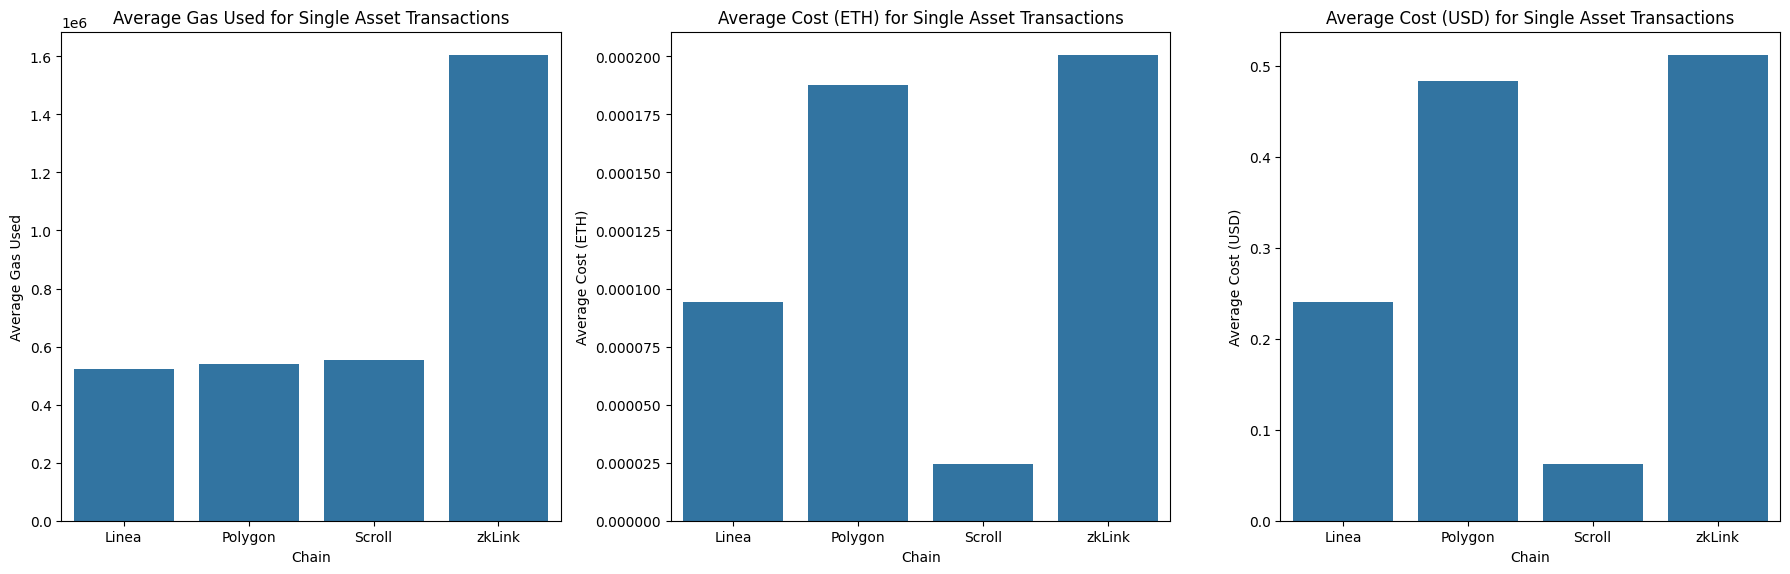

In [34]:
# Plot the average costs in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Average Gas Used
sns.barplot(ax=axes[0], x='Chain', y='Avg Gas Used', data=single_asset_stats)
axes[0].set_title('Average Gas Used for Single Asset Transactions')
axes[0].set_ylabel('Average Gas Used')

# Average Cost in ETH
sns.barplot(ax=axes[1], x='Chain', y='Avg Cost (ETH)', data=single_asset_stats)
axes[1].set_title('Average Cost (ETH) for Single Asset Transactions')
axes[1].set_ylabel('Average Cost (ETH)')

# Average Cost in USD
sns.barplot(ax=axes[2], x='Chain', y='Avg Cost (USD)', data=single_asset_stats)
axes[2].set_title('Average Cost (USD) for Single Asset Transactions')
axes[2].set_ylabel('Average Cost (USD)')

plt.tight_layout()
plt.show()

#### B. Average Cost of Second Asset Price

In [35]:
# Filter transactions with exactly one and two assets
df_one_asset = df[df['Number of Inputs'] == 1]
df_two_assets = df[df['Number of Inputs'] == 2]

# Calculate average gas used and total cost for one-asset transactions
one_asset_stats = df_one_asset.groupby('Chain').agg({
    'Gas Used': 'mean',
    'Total Cost (ETH)': 'mean',
    'Total Cost (USD)': 'mean'
}).rename(columns={
    'Gas Used': 'Avg Gas Used (1 Asset)',
    'Total Cost (ETH)': 'Avg Cost (ETH) (1 Asset)',
    'Total Cost (USD)': 'Avg Cost (USD) (1 Asset)'
})

# Calculate average gas used and total cost for two-asset transactions
two_assets_stats = df_two_assets.groupby('Chain').agg({
    'Gas Used': 'mean',
    'Total Cost (ETH)': 'mean',
    'Total Cost (USD)': 'mean'
}).rename(columns={
    'Gas Used': 'Avg Gas Used (2 Assets)',
    'Total Cost (ETH)': 'Avg Cost (ETH) (2 Assets)',
    'Total Cost (USD)': 'Avg Cost (USD) (2 Assets)'
})

# Merge the stats
second_asset_stats = one_asset_stats.join(two_assets_stats, on='Chain').reset_index()

# Calculate additional gas used for the second asset
second_asset_stats['Additional Gas for Second Asset'] = second_asset_stats['Avg Gas Used (2 Assets)'] - second_asset_stats['Avg Gas Used (1 Asset)']

# Calculate additional cost for each transaction using specific Gas Price and ETH Price
second_asset_stats['Additional Cost (ETH)'] = second_asset_stats['Additional Gas for Second Asset'] * df['Gas Price (ETH)']
second_asset_stats['Additional Cost (USD)'] = second_asset_stats['Additional Cost (ETH)'] * df['ETH Price (USD)']

# Print and plot statistics
print(second_asset_stats)

     Chain  Avg Gas Used (1 Asset)  Avg Cost (ETH) (1 Asset)  \
0    Linea            5.240833e+05                  0.000094   
1  Polygon            5.398027e+05                  0.000188   
2   Scroll            5.548948e+05                  0.000024   
3   zkLink            1.605207e+06                  0.000201   

   Avg Cost (USD) (1 Asset)  Avg Gas Used (2 Assets)  \
0                  0.239811             5.663617e+05   
1                  0.483383             5.491555e+05   
2                  0.062623             5.781615e+05   
3                  0.511844             1.608319e+06   

   Avg Cost (ETH) (2 Assets)  Avg Cost (USD) (2 Assets)  \
0                   0.000102                   0.249984   
1                   0.000238                   0.590878   
2                   0.000028                   0.067765   
3                   0.000201                   0.492685   

   Additional Gas for Second Asset  Additional Cost (ETH)  \
0                     42278.432287       

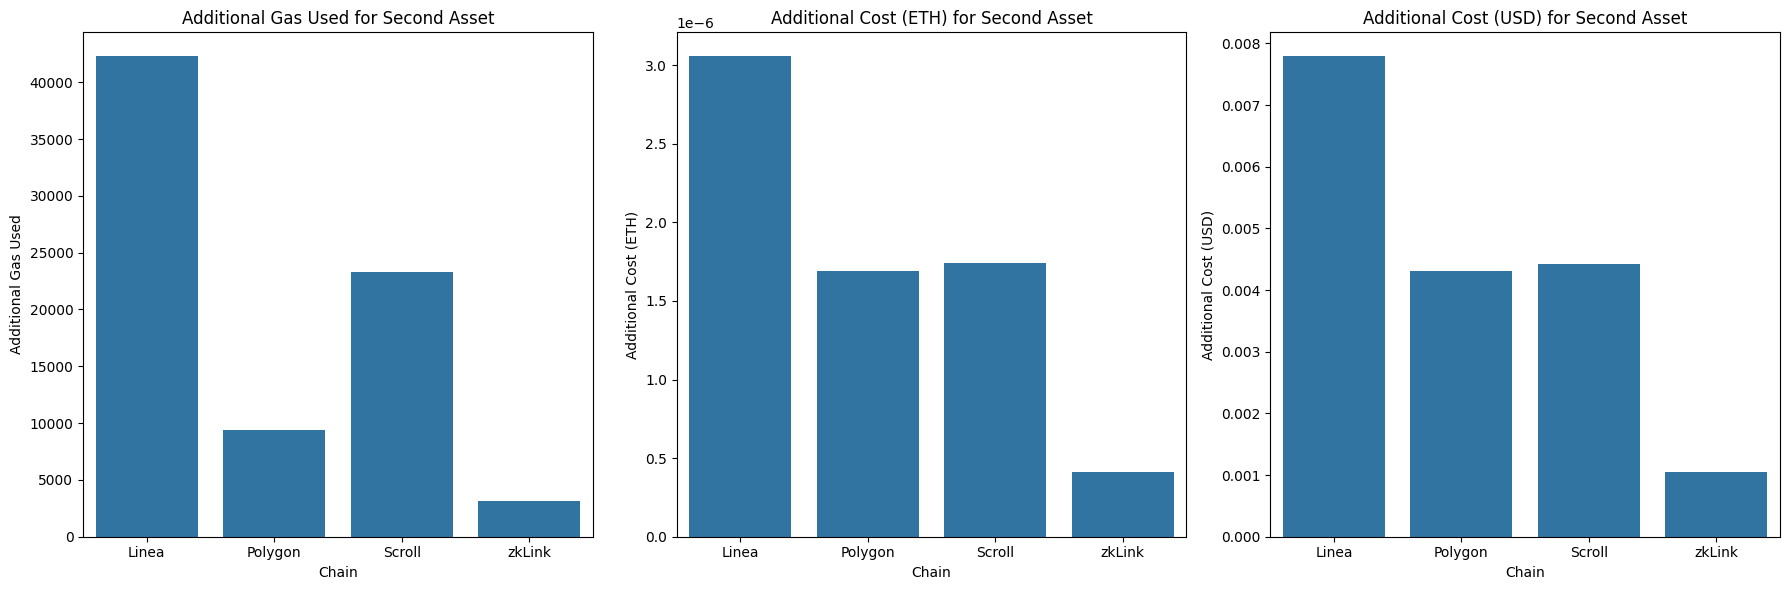

In [36]:
# Plot additional costs in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Additional Gas for Second Asset
sns.barplot(ax=axes[0], x='Chain', y='Additional Gas for Second Asset', data=second_asset_stats)
axes[0].set_title('Additional Gas Used for Second Asset')
axes[0].set_ylabel('Additional Gas Used')

# Additional Cost in ETH
sns.barplot(ax=axes[1], x='Chain', y='Additional Cost (ETH)', data=second_asset_stats)
axes[1].set_title('Additional Cost (ETH) for Second Asset')
axes[1].set_ylabel('Additional Cost (ETH)')

# Additional Cost in USD
sns.barplot(ax=axes[2], x='Chain', y='Additional Cost (USD)', data=second_asset_stats)
axes[2].set_title('Additional Cost (USD) for Second Asset')
axes[2].set_ylabel('Additional Cost (USD)')

plt.tight_layout()
plt.show()

#### C. Single Price Transactions vs. Multi-Price Transactions

In [37]:
# Categorize transactions
df['Transaction Type'] = df['Number of Inputs'].apply(lambda x: 'Single Asset' if x == 1 else 'Multi Asset')

# Count transactions by type and chain
transaction_type_counts = df.groupby(['Chain', 'Transaction Type']).size().reset_index(name='Transaction Count')

print(transaction_type_counts)

     Chain Transaction Type  Transaction Count
0    Linea      Multi Asset               1026
1    Linea     Single Asset               1017
2  Polygon      Multi Asset               1032
3  Polygon     Single Asset                 94
4   Scroll      Multi Asset                131
5   Scroll     Single Asset                126
6   zkLink      Multi Asset               2334
7   zkLink     Single Asset               1903


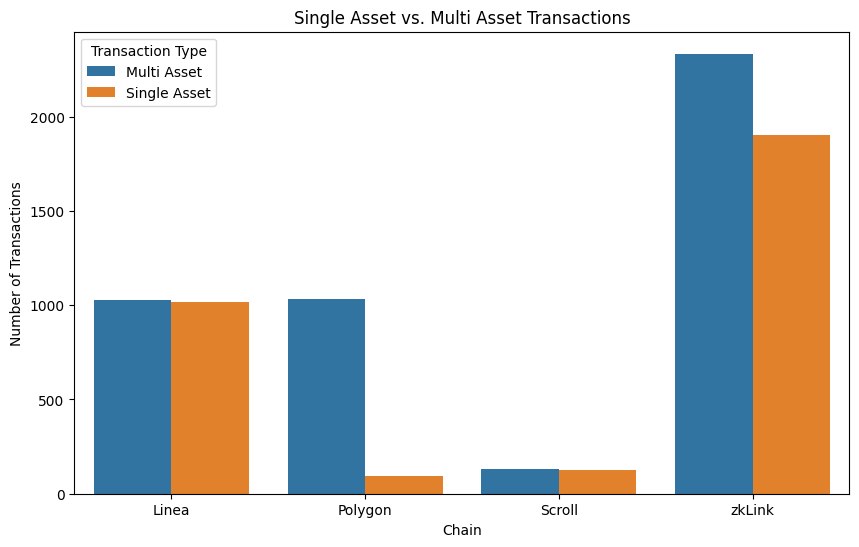

In [38]:
# Plot the transaction counts
plt.figure(figsize=(10, 6))
sns.barplot(x='Chain', y='Transaction Count', hue='Transaction Type', data=transaction_type_counts)
plt.title('Single Asset vs. Multi Asset Transactions')
plt.ylabel('Number of Transactions')
plt.legend(title='Transaction Type')
plt.show()

#### D. Histogram of Multi-Price Transactions

In [39]:
# Filter multi-price transactions (more than one asset)
df_multi_asset = df[df['Number of Inputs'] > 1]

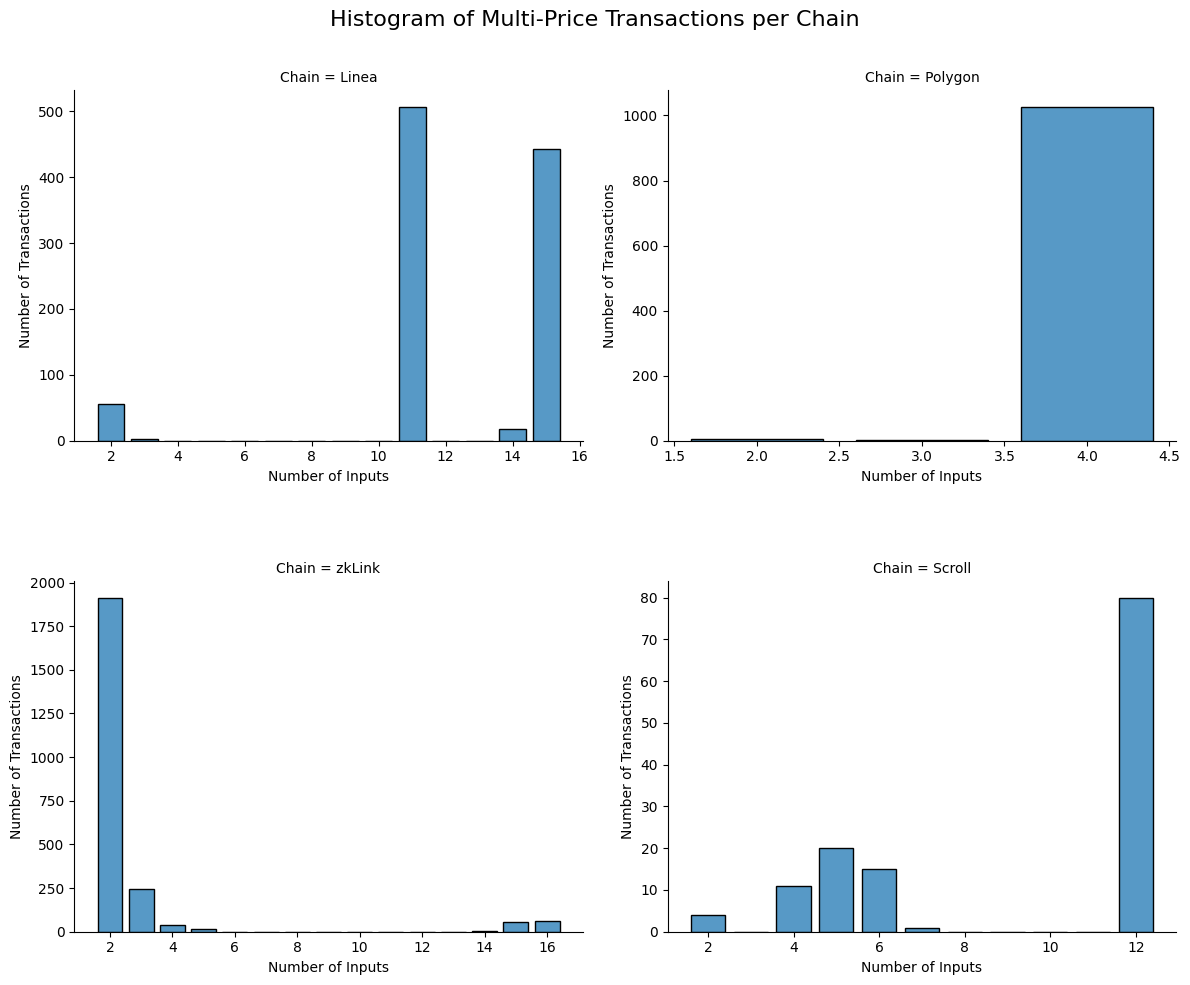

In [40]:
# Plot histogram of number of inputs for multi-asset transactions per chain
g = sns.FacetGrid(df_multi_asset, col='Chain', col_wrap=2, height=5, aspect=1.2, sharex=False, sharey=False)

# Use sns.histplot
g.map_dataframe(sns.histplot, x='Number of Inputs', discrete=True, binwidth=1, shrink=0.8)

# Adjust subplot parameters
g.fig.subplots_adjust(top=0.9, hspace=0.4)

# Set the main title
g.fig.suptitle('Histogram of Multi-Price Transactions per Chain', fontsize=16)

# Set axis labels
for ax in g.axes.flatten():
    ax.set_xlabel('Number of Inputs')
    ax.set_ylabel('Number of Transactions')

plt.show()

#### E. Behavior of Multi-Price Transactions

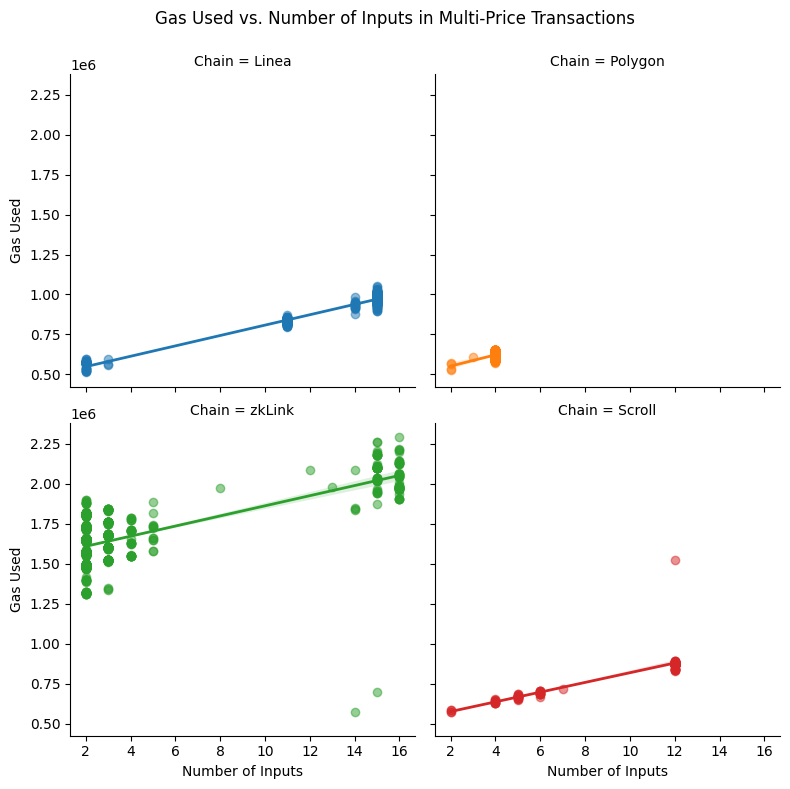

In [41]:
# Plot gas used vs. number of inputs with regression lines per chain
sns.lmplot(data=df_multi_asset, x='Number of Inputs', y='Gas Used', hue='Chain', col='Chain', col_wrap=2, height=4, scatter_kws={'alpha':0.5}, line_kws={'linewidth':2})
plt.subplots_adjust(top=0.9)
plt.suptitle('Gas Used vs. Number of Inputs in Multi-Price Transactions')
plt.show()

#### F. Average Gas Price Per Chain

     Chain  Avg Gas Price (Gwei)
0    Linea              0.157264
1  Polygon              0.247704
2   Scroll              0.043846
3   zkLink              0.125000


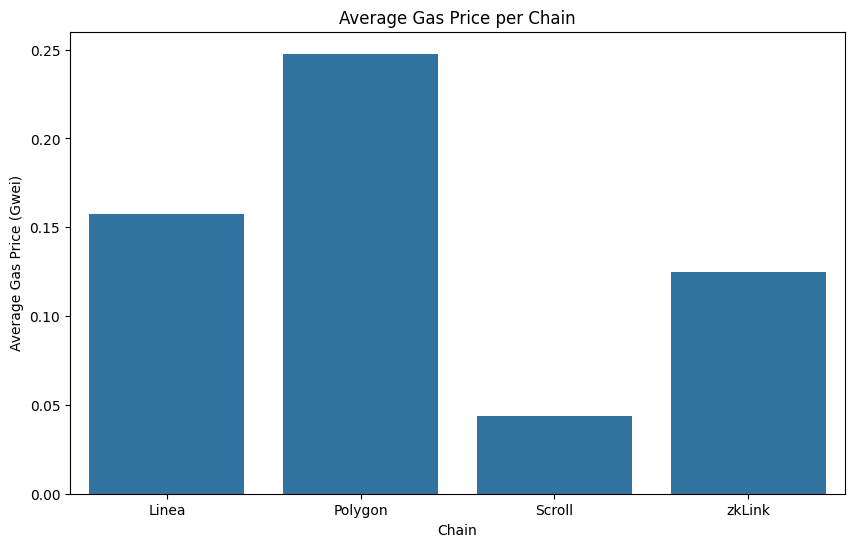

In [42]:
# Calculate average gas price per chain
avg_gas_price = df.groupby('Chain')['Gas Price (Gwei)'].mean().reset_index().rename(columns={'Gas Price (Gwei)': 'Avg Gas Price (Gwei)'})
print(avg_gas_price)

# Plot average gas price
plt.figure(figsize=(10, 6))
sns.barplot(x='Chain', y='Avg Gas Price (Gwei)', data=avg_gas_price)
plt.title('Average Gas Price per Chain')
plt.ylabel('Average Gas Price (Gwei)')
plt.show()


#### G. Correlation Analysis

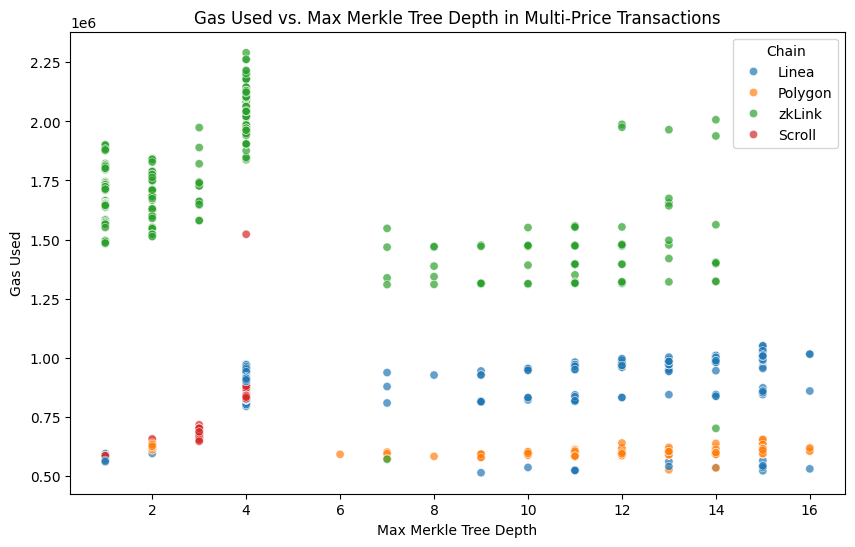

In [43]:
# Plot gas used vs. max merkle tree depth
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_multi_asset, x='Max Merkle Tree Depth', y='Gas Used', hue='Chain', alpha=0.7)
plt.title('Gas Used vs. Max Merkle Tree Depth in Multi-Price Transactions')
plt.xlabel('Max Merkle Tree Depth')
plt.ylabel('Gas Used')
plt.legend(title='Chain')
plt.show()

## **Analysis & Suggested Initiatives**

### **Analysis of Results**

##### **A. Average Cost of Single Asset Transactions**

-Gas Usage: zkLink requires significantly more gas (~1.6 million units) for single-asset transactions compared to Linea, Polygon, and Scroll (~0.5 million units).

-Cost in ETH and USD:
Despite higher gas usage, zkLink's average cost in ETH (0.000201 ETH) is comparable to Polygon's (0.000188 ETH).
Scroll has the lowest average cost in both ETH (0.000024 ETH) and USD ($0.06), making it the most cost-effective chain for single-asset transactions.

##### **B. Average Cost of Adding a Second Asset**

-Additional Gas Used:
Linea incurs the highest additional gas (~42,278 units) when adding a second asset.
zkLink requires the least additional gas (~3,112 units).

-Additional Cost:
In USD, Linea has the highest additional cost ($0.0078), while zkLink has the lowest ($0.0011).
The additional cost in ETH mirrors this pattern.

-Cost Efficiency:
zkLink is the most efficient in handling additional assets, requiring minimal extra gas and cost.
Linea's high additional gas usage suggests inefficiency in multi-asset transactions.

##### **C. Single vs. Multi-Asset Transactions**

-Transaction Counts:
zkLink has the highest number of both single-asset (1,903) and multi-asset (2,334) transactions.
Polygon shows a strong preference for multi-asset transactions (1,032) over single-asset ones (94).

-Chain Preferences:
Operators on Polygon and zkLink favor multi-asset transactions.
Scroll and Linea have a more balanced distribution.

-Operational Strategies:
The high number of multi-asset transactions on Polygon and zkLink indicates strategies aimed at optimizing costs by bundling assets.

-Potential for Optimization:
Chains with a balanced distribution might benefit from encouraging more multi-asset transactions to reduce overall costs.

##### **D. Histogram of Multi-Asset Transactions**

-Asset Bundling Patterns:
zkLink predominantly processes transactions with 2 assets (~1,900 transactions).
Linea shows peaks at transactions with 11 and 15 assets.

-Frequency Distribution:
Scroll and Polygon have fewer multi-asset transactions and a more uniform distribution around 12 and 4 assets respectively.

-Operator Behavior: zkLink and Polygon operators prefer small bundles, possibly due to diminishing returns on gas savings with more assets. Linea and Scroll operators bundle many assets, which could lead to higher individual transaction costs.

##### **E. Gas Usage vs. Number of Inputs**

-Scaling Relationship:
Gas used increases with the number of inputs across all chains.
The rate of increase varies slightly, with Linea having the steepest slope.

-Optimal Transaction Size:
There may be an optimal number of assets to include in a transaction before the additional gas cost outweighs the benefits.

-Chain-Specific Strategies:
Operators should consider chain-specific behaviors when deciding how many assets to bundle.



##### **F. Average Gas Price Per Chain**

-Gas Price Variation:
Polygon has the highest average gas price (0.248 Gwei), contributing to higher transaction costs.
Scroll has the lowest gas price (0.044 Gwei), enhancing its cost-effectiveness.

-Cost Management:
Operators can manage costs by choosing chains with lower gas prices when possible.

-Market Conditions:
Gas prices are influenced by network demand, so timing transactions during lower demand could reduce costs.


##### **G. Gas Usage vs. Merkle Tree Depth**

-Impact of Merkle Tree Depth:
Gas usage increases with Merkle tree depth up to a depth of 4, then stabilizes.
The initial increase highlights the higher computational effort for deeper trees.

-Optimization Opportunity:
Limiting the Merkle tree depth to 4 could minimize gas usage without sacrificing security.

-Design Considerations:
Efficient tree structures can lead to cost savings.

### **Suggested Initiatives for Improving Operator Behavior**

Based on the analysis above, I propose the following initiatives to optimize operator behavior and reduce costs:

**1. Optimize Asset Bundling Strategies**
<br>**-Find the Sweet Spot**: Operators should determine the optimal number of assets to include in a transaction. The goal is to maximize gas savings per asset without incurring disproportionate additional gas costs.
<br>**-Chain-Specific Approaches**: On zkLink, since the additional gas cost per asset is low, operators can benefit from bundling more assets. On Linea, due to higher additional gas costs, operators might limit the number of assets per transaction.

**2. Leverage Chains with Lower Gas Prices**
<br>**-Cost-Efficient Chains**: Operators should consider using chains like Scroll, which have lower gas prices, for cost-sensitive transactions.
<br>**-Dynamic Chain Selection**: Implement systems that select the chain with the most favorable gas prices at the time of transaction.

**3. Schedule Transactions During Low Network Demand**
<br>**-Gas Price Fluctuations**: Monitor network conditions to execute transactions when gas prices are lower, reducing costs.
<br>**-Automation**: Use automated tools to queue and execute transactions at optimal times.

**4. Optimize Merkle Tree Structures**
<br>**-Limit Merkle Tree Depth**: Keeping the Merkle tree depth at or below 4 can minimize gas usage.
<br>**-Efficient Proofs**: Develop or adopt algorithms that generate efficient Merkle proofs to reduce computational overhead.

**5. Encourage Multi-Asset Transactions Where Beneficial**
<br>**-Cost Savings**: Bundling assets can lead to significant gas savings per asset, especially on chains where the additional gas cost per asset is low.
<br>**-Operator Education**: Provide resources and guidelines to operators on the benefits and best practices of multi-asset transactions.

**6. Implement Adaptive Publishing Strategies**
<br>**-Deviation-Based Publishing**: Adjust the frequency of publishing based on price deviations, reducing unnecessary transactions.
<br>**-Threshold Optimization**: Determine the optimal deviation thresholds (n%) that trigger publishing, balancing accuracy and cost.

**7. Monitor and Adjust for Gas Price Variability**
<br>**-Real-Time Gas Price Tracking**: Integrate gas price oracles to obtain real-time data and adjust transaction strategies accordingly.
<br>**-Budget Constraints**: Set gas price limits to prevent transactions from occurring when costs exceed acceptable thresholds.

**8. Analyze Transaction Histories for Outliers**
<br>**-Data Cleaning**: Regularly analyze transaction data to identify and address anomalies or outliers that may skew cost calculations.
<br>**-Performance Metrics**: Establish key performance indicators (KPIs) to monitor the efficiency of transactions over time.

